# Classification
### Course: Astroinformatics
### Profs: Francisco Forster; Valentino Gonzalez
### Author: Jose Vines
### Mail: jose.vines@ug.uchile.cl

In this demo we'll go through supervised machine learning studying the population of exoplanets and galaxies. We have been given three files, `Radii.dat`, `Mass-period.dat`, and `galaxies.csv`. The first has the radii of several exoplanets in units of Earth radius and a clasification tag according to their equilibrium temperature which can be either 0 for a cold planet or 1 for a hot planet. In case you don't know, the equilibrium temperature of a planet is a theoretical temperature a planet would have if it was a black body. We can calculate this temperature if we know the albedo of the planet and the incident stellar flux as follows

$$
T_{\rm eq} = \left( \frac{I_0\left(1-A_B\right)}{4\sigma} \right)^{1/4}
$$

Where $\sigma$ is the Stefan-Boltzmann constant, $A_B$ the planet's albedo and $I_0$ the incident stellar flux.

The threshold for hot or cold was chosen to be 1250 K for this particular case!

The second dataset includes the mass and orbital period of several exoplanets along with a tag which characterizes the discovery method, which are 0 for Radial Velocity and 1 for Transits. The source of these datasets is the [NASA Exoplanet Archive](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS&constraint=default_flag=1).

The third dataset contains various information of different galaxies, it contains the $g - i$ and $M_i$ magnitudes necessary to construct the color magnitude diagram for galaxies and three different tags: elliptical, spiral or uncertain galaxies.

We are going to perform classification following the procedure [seen in the lectures](https://github.com/fforster/AS4501/blob/main/ML_supervised/Classification_FF_AS4501.ipynb) and we'll study the different metrics and the confusion matrix.

Before starting we'll import the relevant modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# For splitting the data into training and testing!
from sklearn.model_selection import train_test_split
# Import a couple of classifiers
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
# Now the metrics
from sklearn import metrics

In [2]:
%matplotlib inline

Now we read our file

In [3]:
radii, tags = np.loadtxt('assets/Radii.dat', unpack=True)

Let's plot our data to see what we're working with

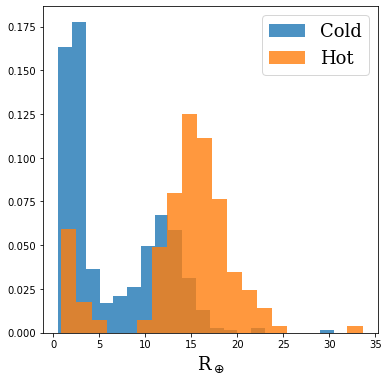

In [4]:
f, ax = plt.subplots(figsize=(6, 6))

ax.hist(radii[tags==0], density=1, alpha=0.8, bins=20, label='Cold')
ax.hist(radii[tags==1], density=1, alpha=0.8, bins=20, label='Hot')

ax.set_xlabel(r'R$_\oplus$', fontname='serif', fontsize=18)
ax.legend(loc=0, prop={'size':18, 'family':'serif'});

Now we're going to split the data and plot it again

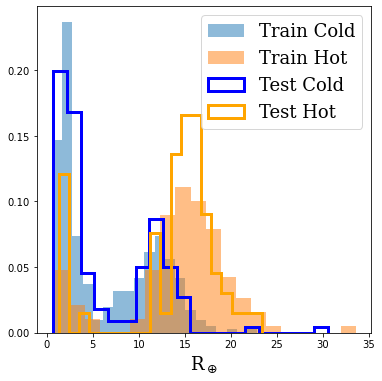

In [5]:
rad_train, rad_test, tag_train, tag_test = train_test_split(radii, tags, test_size=0.3)
f, ax = plt.subplots(figsize=(6, 6))

ax.hist(rad_train[tag_train==0], density=1, alpha=0.5, bins=20, label='Train Cold', color='tab:blue')
ax.hist(rad_train[tag_train==1], density=1, alpha=0.5, bins=20, label='Train Hot', color='tab:orange')
ax.hist(rad_test[tag_test==0], density=1, bins=20, label='Test Cold', histtype='step', color='b', lw=3)
ax.hist(rad_test[tag_test==1], density=1, bins=20, label='Test Hot', histtype='step', color='orange', lw=3)

ax.set_xlabel(r'R$_\oplus$', fontname='serif', fontsize=18)
ax.legend(loc=0, prop={'size':18, 'family':'serif'});

Now we'll train our model. We'll start with a [c-support vector classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC). Since our data has only one feature, first we must reshape it into a 2D array with shape Ndata,1

In [6]:
reshaped_rad_train = rad_train.reshape(-1, 1)
reshaped_rad_test = rad_test.reshape(-1, 1)

clf = SVC(kernel='linear', C=0.01, probability=True)
clf.fit(reshaped_rad_train, tag_train)
tag_test_pred = clf.predict_proba(reshaped_rad_test)[:, 1]

Now we'll do some more plots!

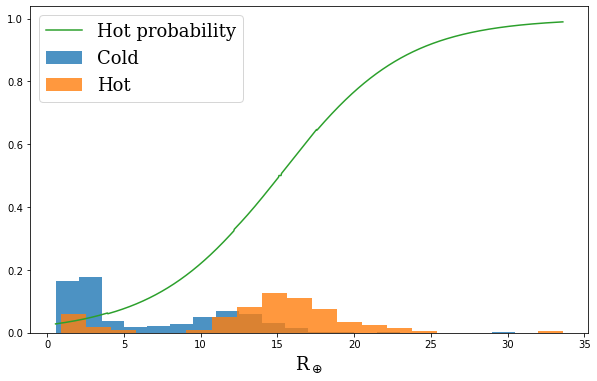

In [7]:
f, ax = plt.subplots(figsize=(10, 6))

ax.hist(radii[tags==0], density=1, alpha=0.8, bins=20, label='Cold')
ax.hist(radii[tags==1], density=1, alpha=0.8, bins=20, label='Hot')

xx = np.linspace(radii.min(), radii.max(), 1000)

xx = xx.reshape(-1, 1)

ax.plot(xx, clf.predict_proba(xx)[:, 1], label='Hot probability')

ax.set_xlabel(r'R$_\oplus$', fontname='serif', fontsize=18)
ax.legend(loc=0, prop={'size':18, 'family':'serif'});

Let's get the Receiver Operating Characteristics (ROC) curve. Remember this curve shows the trade-off between the recall and precision of a clasifier. In other words, we get the true postive vs the false positive rate per threshold. In addition, we'll calculate the Area Under the Curve (AUC) which is a measure of the performance of the classifier.

The takeaways are that the ROC is a probability curve and the AUC shows how much the model is capable of distinguishing between classes, so 1 would be a perfect classifier

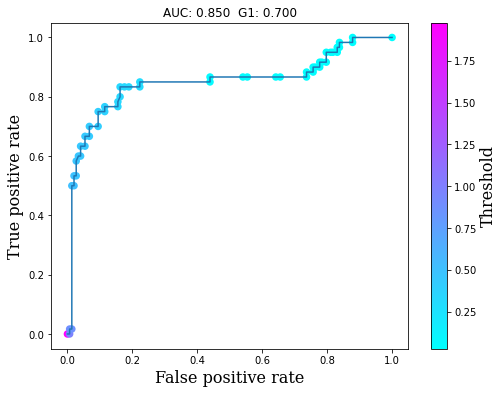

In [8]:
# get the ROC curve
fpr, tpr, thresh = metrics.roc_curve(tag_test, tag_test_pred, pos_label=1)
fig, ax = plt.subplots(figsize=(8, 6))
auc = metrics.roc_auc_score(tag_test, tag_test_pred)
gini = 2 * auc - 1
ax.set_title(f"AUC: {auc:.3f}  G1: {gini:.3f}")
ax.plot(fpr, tpr)
sc = ax.scatter(fpr, tpr, lw=1.5, c=thresh, cmap='cool')
cb = plt.colorbar(sc)
cb.set_label('Threshold', fontname='serif', fontsize=16)
ax.set_xlabel("False positive rate", fontname='serif', fontsize=16)
ax.set_ylabel("True positive rate", fontname='serif', fontsize=16);

Let's check out another metric, the accuracy score

In [9]:
metrics.accuracy_score(tag_test, clf.predict(reshaped_rad_test))

0.8173076923076923

Let's try out the [Gaussian Process Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html#sklearn.gaussian_process.GaussianProcessClassifier). The GPC can use various [kernels](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.gaussian_process), but the default one is the Radial-basis function (RBF). Let's see how it goes

In [10]:
rad_train, rad_test, tag_train, tag_test = train_test_split(radii, tags, test_size=0.4)

reshaped_rad_train = rad_train.reshape(-1, 1)
reshaped_rad_test = rad_test.reshape(-1, 1)

gpclf = GaussianProcessClassifier()
gpclf.fit(reshaped_rad_train, tag_train)
tag_test_pred = gpclf.predict_proba(reshaped_rad_test)[:, 1]

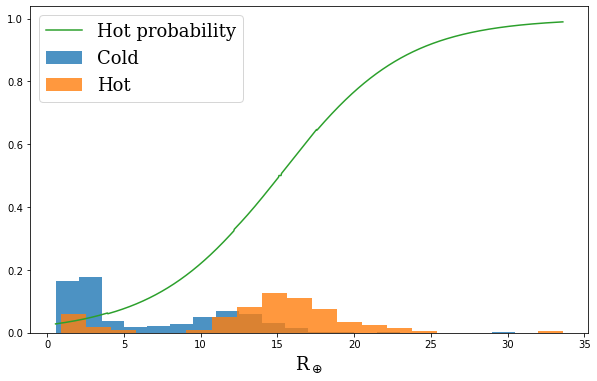

In [11]:
f, ax = plt.subplots(figsize=(10, 6))

ax.hist(radii[tags==0], density=1, alpha=0.8, bins=20, label='Cold')
ax.hist(radii[tags==1], density=1, alpha=0.8, bins=20, label='Hot')

xx = np.linspace(radii.min(), radii.max(), 1000)

xx = xx.reshape(-1, 1)

ax.plot(xx, clf.predict_proba(xx)[:, 1], label='Hot probability')

ax.set_xlabel(r'R$_\oplus$', fontname='serif', fontsize=18)
ax.legend(loc=0, prop={'size':18, 'family':'serif'});

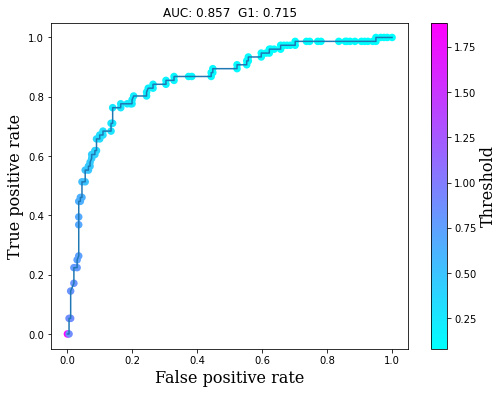

In [12]:
# get the ROC curve
fpr, tpr, thresh = metrics.roc_curve(tag_test, tag_test_pred, pos_label=1)
fig, ax = plt.subplots(figsize=(8, 6))
auc = metrics.roc_auc_score(tag_test, tag_test_pred)
gini = 2 * auc - 1
ax.set_title(f"AUC: {auc:.3f}  G1: {gini:.3f}")
ax.plot(fpr, tpr)
sc = ax.scatter(fpr, tpr, lw=1.5, c=thresh, cmap='cool')
cb = plt.colorbar(sc)
cb.set_label('Threshold', fontname='serif', fontsize=16)
ax.set_xlabel("False positive rate", fontname='serif', fontsize=16)
ax.set_ylabel("True positive rate", fontname='serif', fontsize=16);

We'll now show the F1 score and see how it varies with the probability threshold

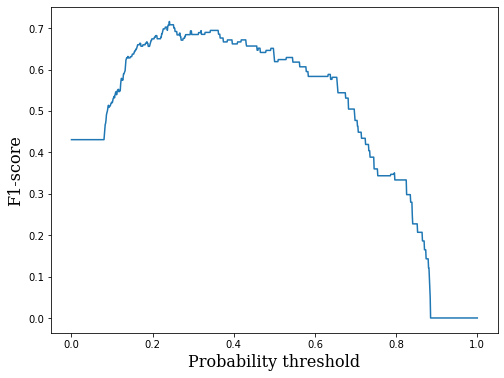

In [13]:
def f1_prob(prob, true, pred):
    return metrics.f1_score(true, pred >= prob)

probs = np.linspace(0, 1, 1000)
f1scores = np.zeros_like(probs)
for i in range(len(probs)):
    f1scores[i] = f1_prob(probs[i], tag_test, tag_test_pred)
    

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(probs, f1scores)
ax.set_xlabel('Probability threshold', fontsize=16, fontname='serif')
ax.set_ylabel('F1-score', fontsize=16, fontname='serif');

Now we can see both method's AUC and see which one performs better.

Remember, though, we used the default kernel! What if there are other kernels that perform better? Well, we can test that using cross-validation! Let's give it a try, we'll test out different kernels and see how they perform with the accuracy score. First we need to import the kernels

In [14]:
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel

Now we'll import the [GridSearchCV class](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) which is a class designed to do cross-validation over a grid of hyperparameters. In this case our hyperparameters will be the kernels themselves. The cross-validation itself will be done using the [K-Fold cross-validator](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold)

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# We define the model here
model = GaussianProcessClassifier()
# Now the cross-validator or evaluation method
cv = KFold()
# Now we degine our grid
grid = dict()
grid['kernel'] = [1*RBF(), 1*DotProduct(), 1*Matern(),  1*RationalQuadratic(), 1*WhiteKernel()]
# Here we define how our search will work
search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)
# Now we do the search
results = search.fit(reshaped_rad_train, tag_train)

Let's have a look at the results now

In [16]:
# Summarize all results
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
    print(f">{mean:.3f} with: {param}")

>0.867 with: {'kernel': 1**2 * RBF(length_scale=1)}
>0.860 with: {'kernel': 1**2 * DotProduct(sigma_0=1)}
>0.862 with: {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
>0.867 with: {'kernel': 1**2 * RationalQuadratic(alpha=1, length_scale=1)}
>0.759 with: {'kernel': 1**2 * WhiteKernel(noise_level=1)}


In this case we can see that the RBF, Matern, and Rational Quadratic kernel are tied for the best score.

Now we should take a look at the confusion matrix. Remember this matrix shows the rates of false positives

In [17]:
# Function to pretty print the confusion matrix

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, size=(8,8)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig = plt.figure(figsize=size)
    gs = gridspec.GridSpec(1, 2, width_ratios=(40,1), wspace=0.05)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
    else:
#         print('Confusion matrix, without normalization')
        pass

    ax = fig.add_subplot(gs[0])
    cax = fig.add_subplot(gs[1])
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title, fontname='serif', fontsize=20)
    cbar = f.colorbar(im, cax=cax, pad=0.5)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks, classes)
    ax.set_yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    ax.set_ylabel('True label', fontname='serif', fontsize=16)
    ax.set_xlabel('Predicted label', fontname='serif', fontsize=16)
    return fig, ax

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


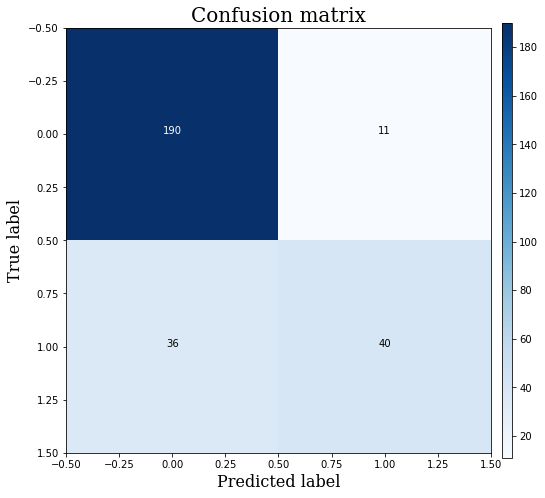

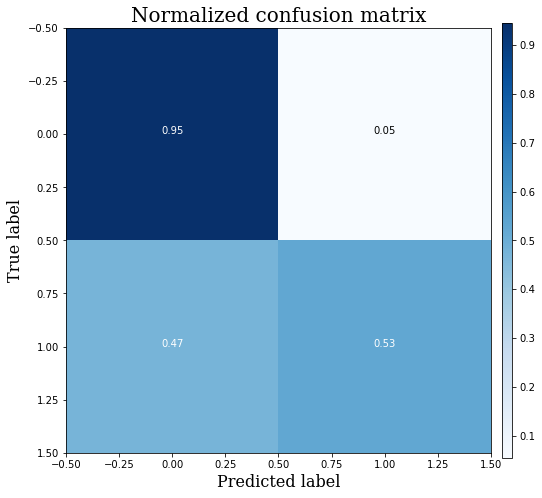

In [18]:
fig, ax = plot_confusion_matrix(metrics.confusion_matrix(tag_test, tag_test_pred >= 0.5), range(2))

fig, ax = plot_confusion_matrix(metrics.confusion_matrix(tag_test, tag_test_pred >= 0.5), range(2),
                     normalize=True, title='Normalized confusion matrix')

This dataset is quite interesting, considering that for the solar system it's the other way around, smaller planets are hotter! This brings up the question, are there any biases that might affect the classification algorithms??

Let's move on to our next dataset!

In [19]:
mass, period, tags = np.loadtxt('assets/Mass_period.dat', unpack=True)

As always, plot your data first!

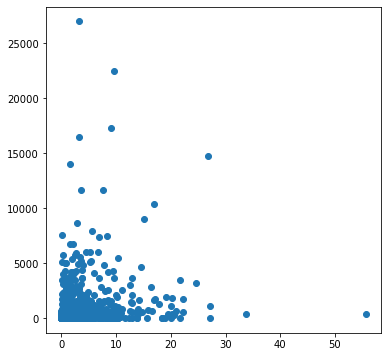

In [20]:
f, ax = plt.subplots(figsize=(6, 6))

ax.scatter(mass, period);

This doesn't look right. Let's try a logarithmic scale for the x and y axis!

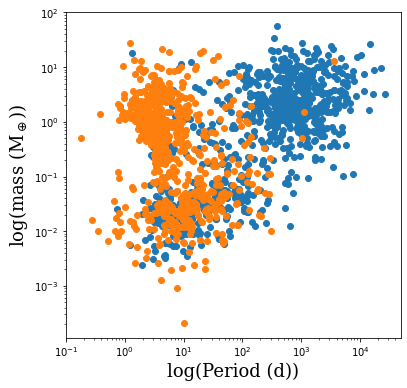

In [21]:
f, ax = plt.subplots(figsize=(6, 6))

ax.scatter(period[tags==0], mass[tags==0])
ax.scatter(period[tags==1], mass[tags==1])
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('log(Period (d))', fontname='serif', fontsize=18)
ax.set_ylabel(r'log(mass (M$_\oplus$))', fontname='serif', fontsize=18);

That's looking much better! Now we're going to test a couple of classicfication models

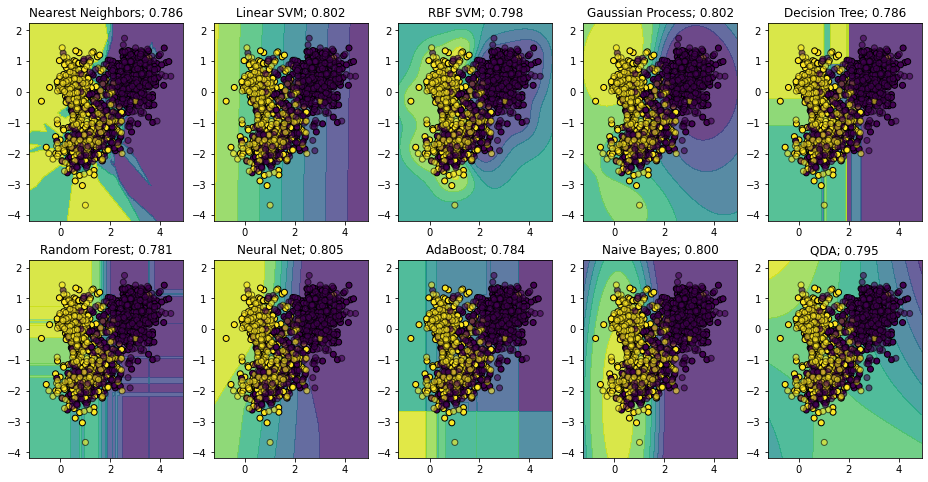

In [22]:
h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

preds = []

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=2, C=1, probability=True),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X = np.stack((np.log10(period), np.log10(mass))).T

X_train, X_test, tag_train, tag_test = train_test_split(X, tags, test_size=0.4)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

figure = plt.figure(figsize=(16, 8))

i = 1
for name, clf in zip(names, classifiers):
    ax = plt.subplot(2, len(classifiers)//2, i)
    clf.fit(X_train, tag_train)
    tag_test_pred = clf.predict_proba(X_test)[:, 1]
    preds.append(tag_test_pred)
    score = clf.score(X_test, tag_test)
    
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap='viridis', alpha=.8)
    
    ax.scatter(X_train[:, 0], X_train[:, 1], c=tag_train, cmap='viridis', edgecolors='k')
    ax.scatter(X_test[:, 0], X_test[:, 1], c=tag_test, cmap='viridis', edgecolors='k', alpha=0.6)
    ax.set_title(f'{name}; {score:.3f}')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    
    i+=1

Let's see how the confusion matrices look

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


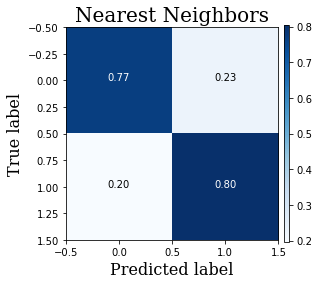

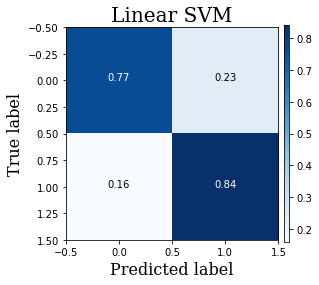

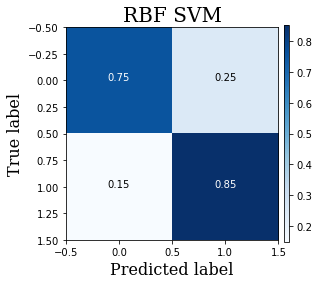

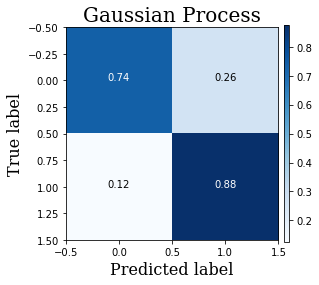

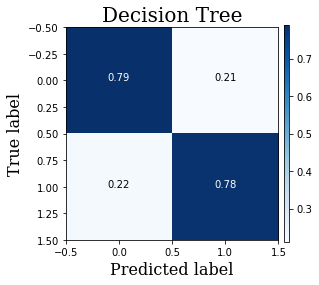

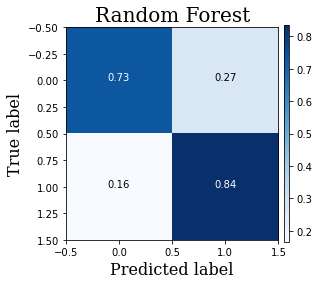

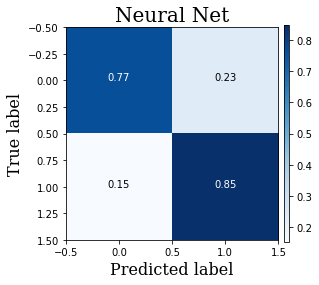

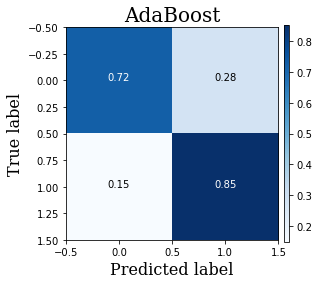

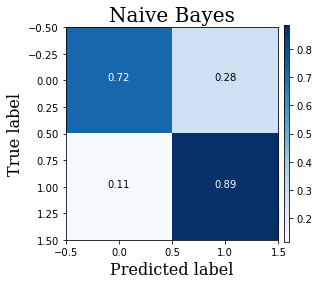

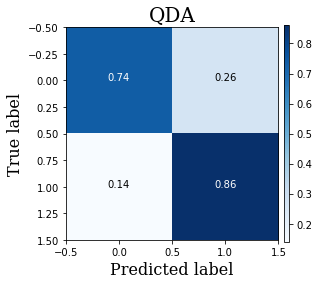

In [23]:
for i, name in enumerate(names):
    plot_confusion_matrix(metrics.confusion_matrix(tag_test, preds[i] >= 0.5), range(2),
                     normalize=True, title=f'{name}', size=(4,4));

Let's put what we've learned to the test and create the ROC curves for these classificators!

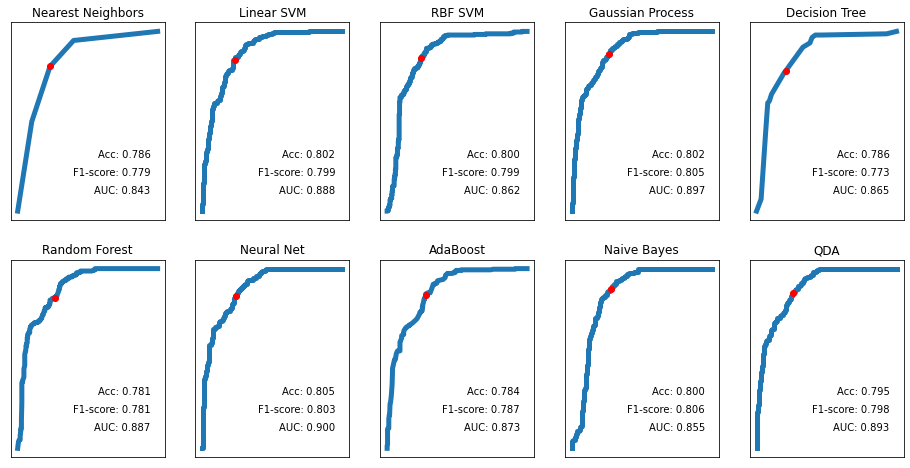

In [24]:
figure = plt.figure(figsize=(16, 8))

for i, name in enumerate(names):
    ax = plt.subplot(2, len(classifiers)//2, i + 1)
    
    
    fpr, tpr, thresholds = metrics.roc_curve(tag_test, preds[i], pos_label=1)
    auc = metrics.roc_auc_score(tag_test, preds[i])
    acc = metrics.accuracy_score(tag_test, preds[i] >= 0.5)
    f1 = metrics.f1_score(tag_test, preds[i] >= 0.5)
    
    ax.set_title(f'{name}')
    
    ax.set_xlim(-.05, 1.05)
    ax.set_ylim(-.05, 1.05)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.text(0.95, 0.3, "Acc: %.3f" % acc, ha = 'right')
    ax.text(0.95, 0.2, "F1-score: %.3f" % f1, ha = 'right')
    ax.text(0.95, 0.1, "AUC: %.3f" % auc, ha = 'right')
    ax.plot(fpr, tpr, lw = 5)
    idx = np.argmin(np.abs(thresholds - 0.5))
    ax.scatter(fpr[idx], tpr[idx], marker='o', c='r', zorder=10)

Let's move onto our final dataset, the galaxy color-magnitude diagram!

Since this file is a `.csv`, we can read it with pandas, this might make filtering and such easier for us as opposed to using pure numpy ;)

In [25]:
df = pd.read_csv('assets/galaxies.csv')
df

,RA,DEC,Z,NVOTE,SPIRAL,ELLIPTICAL,UNCERTAIN,gminusi,vhelio,absmagi
0,147.329505,0.028895,0.048086,25,1,0,0,1.212299,14415.762196,-21.261998
1,146.323172,-0.029952,0.021709,34,0,0,1,0.450300,6508.135424,-18.274793
2,146.300911,0.035489,0.021758,52,0,0,1,0.873799,6522.885215,-19.087308
3,146.329665,-0.306222,0.036452,59,0,0,1,0.994801,10927.976252,-19.611009
4,146.057311,-0.097027,0.036730,60,0,1,0,1.419101,11011.468463,-20.655536
...,...,...,...,...,...,...,...,...,...,...
32123,198.994002,1.448322,0.053900,32,0,1,0,1.689600,16158.815750,-20.661358
32124,199.538837,0.222813,0.031491,38,0,0,1,0.600600,9440.825576,-20.618860
32125,208.122689,1.915619,0.032600,25,0,0,1,2.016100,9773.235500,-19.932301
32126,204.977039,2.122185,0.023074,29,0,0,1,0.601901,6917.322207,-19.423800


First let's filter our data to get only the spirals, ellipticals and the uncertain ones

In [26]:
nans = ~np.isnan(df['absmagi'])
ellf = df['ELLIPTICAL'] == 1
spif = df['SPIRAL'] == 1
uncf = df['UNCERTAIN'] == 1
# ellf &= nans
# spif &= nans
# uncf &= nans

Now... We plot!

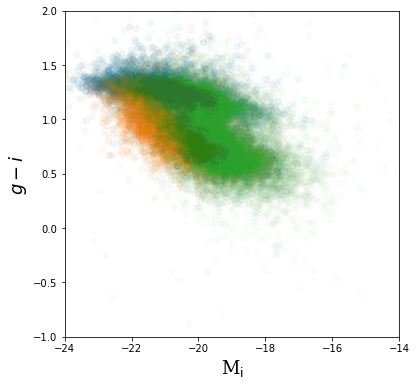

In [27]:
f, ax = plt.subplots(figsize=(6, 6))

ax.scatter(df['absmagi'][ellf], df['gminusi'][ellf], alpha=.05)
ax.scatter(df['absmagi'][spif], df['gminusi'][spif], alpha=.05)
ax.scatter(df['absmagi'][uncf], df['gminusi'][uncf], alpha=.02)

ax.set_ylim([-1, 2])
ax.set_xlim([-24, -14])
ax.set_ylabel(r'$g - i$', fontname='serif', fontsize=18)
ax.set_xlabel(r'M$_{\rm i}$', fontname='serif', fontsize=18);

Note how most galaxies are classified as uncertain! So much we need to use a smaller alpha value or else everything would look green

Let's do a multiclass regression now

In [28]:
X = df[['absmagi', 'gminusi']][nans].to_numpy()
# We'll tag ellipticals as 1, spirals as 2 and uncertain as 3
y = df['ELLIPTICAL'][nans] + df['SPIRAL'][nans] * 2 + df['UNCERTAIN'][nans] * 3

clf = SVC(gamma=2, C=1, probability=True)
clf.fit(X, y)

SVC(C=1, gamma=2, probability=True)

(-24.0, -14.0)

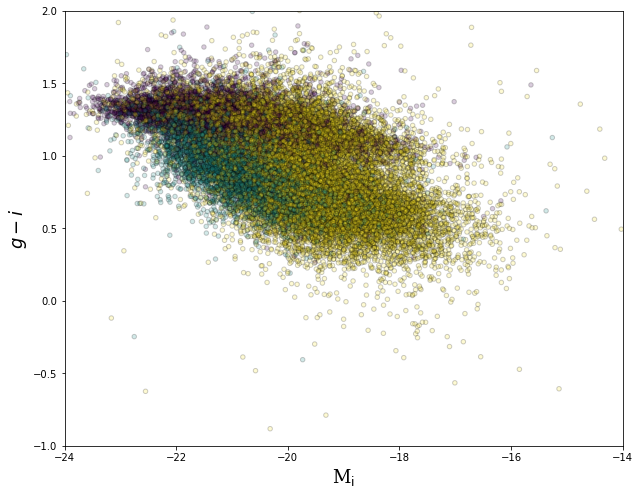

In [29]:
figure = plt.figure(figsize=(10, 8))

ax = plt.subplot()

X0, X1 = X[:, 0], X[:, 1]

ax.scatter(X0, X1, c=y, cmap='viridis', s=20, edgecolors='k', alpha=0.2)

ax.set_ylabel(r'$g - i$', fontname='serif', fontsize=18)
ax.set_xlabel(r'M$_{\rm i}$', fontname='serif', fontsize=18)
ax.set_ylim([-1, 2])
ax.set_xlim([-24, -14])

Now try creating a confusion matrix and showing different metrics! Maybe even try and use other kernels and see which one is better. A word of caution, the dataset is large and thus the classification might take long